<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Hands-On-ML2/Chapter-15/Chapter_15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.executable)


C:\Users\hamda\tf-env\Scripts\python.exe


In [ ]:
!pip install matplotlib
!pip install pandas
!pip install numpy pandas matplotlib seaborn scikit-learn


In [ ]:
# Setup awal
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

# Pastikan versi
assert tf.__version__ >= "2.0"
print("TensorFlow version:", tf.__version__)

# Cek GPU
device_info = tf.config.list_physical_devices('GPU')
if not device_info:
    print("⚠️ GPU tidak terdeteksi. Jalankan di Colab dengan GPU (Runtime > Change runtime type > GPU).")
else:
    print("✅ GPU terdeteksi:", device_info[0].name)

# Set seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Direktori penyimpanan gambar
def save_plot(name, tight_layout=True, fmt='png', dpi=300):
    directory = os.path.join(".", "figures", "ch15")
    os.makedirs(directory, exist_ok=True)
    path = os.path.join(directory, f"{name}.{fmt}")
    print(f"📌 Menyimpan gambar ke: {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fmt, dpi=dpi)

# Fungsi generator time series
def create_time_series(batch_size, steps):
    phase1, phase2, f1, f2 = np.random.rand(4, batch_size, 1)
    timeline = np.linspace(0, 1, steps)
    signal = 0.5 * np.sin((timeline - phase1) * (f1 * 10 + 10))
    signal += 0.2 * np.sin((timeline - phase2) * (f2 * 20 + 20))
    signal += 0.1 * (np.random.rand(batch_size, steps) - 0.5)
    return signal[..., np.newaxis].astype(np.float32)

# Generate dataset
n_steps = 50
dataset = create_time_series(10000, n_steps + 1)

X_train, y_train = dataset[:7000, :n_steps], dataset[:7000, -1]
X_valid, y_valid = dataset[7000:9000, :n_steps], dataset[7000:9000, -1]
X_test, y_test = dataset[9000:, :n_steps], dataset[9000:, -1]

print("✅ Data shape:", X_train.shape, y_train.shape)


TensorFlow version: 2.19.0
⚠️ GPU tidak terdeteksi. Jalankan di Colab dengan GPU (Runtime > Change runtime type > GPU).
✅ Data shape: (7000, 50, 1) (7000, 1)


📌 Menyimpan gambar ke: .\figures\ch15\tiga_series_validasi.png


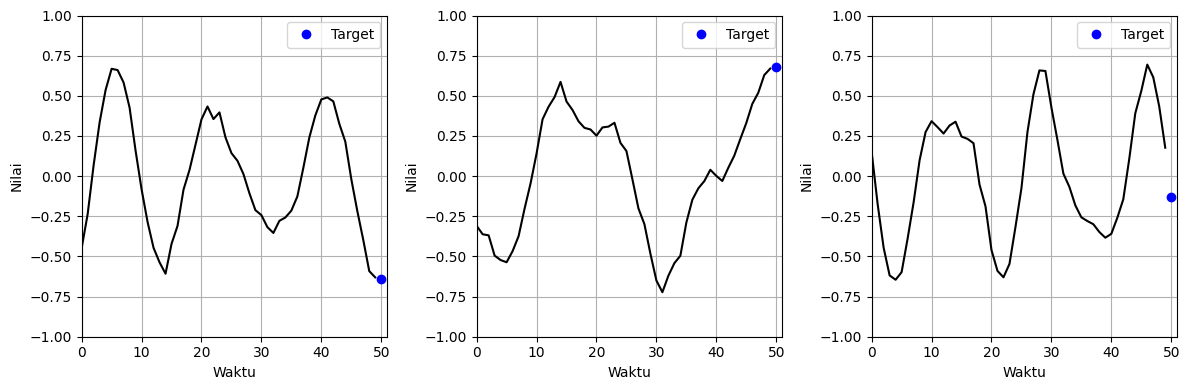

In [ ]:
# Fungsi plotting time series
def tampilkan_series(data, target=None, prediksi=None, judul_x="Waktu", judul_y="Nilai", legend=True):
    plt.plot(data, "k-")
    if target is not None:
        plt.plot(n_steps, target, "bo", label="Target")
    if prediksi is not None:
        plt.plot(n_steps, prediksi, "rx", label="Prediksi", markersize=10)
    plt.grid(True)
    plt.xlabel(judul_x)
    plt.ylabel(judul_y)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (target is not None or prediksi is not None):
        plt.legend()

# Plot 3 series dari validation set
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    tampilkan_series(X_valid[i, :, 0], y_valid[i, 0] if y_valid.ndim > 1 else y_valid[i])
plt.tight_layout()
save_plot("tiga_series_validasi")
plt.show()


In [ ]:
# naive_mse = tf.keras.metrics.mean_squared_error(y_valid, y_pred_naive).numpy().mean()


📉 Naive Forecasting MSE: 0.019689064


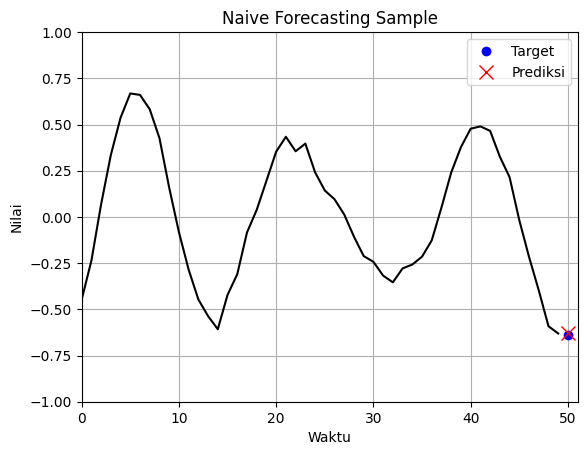

In [ ]:
# Ulangi prediksi naive
y_pred_naive = X_valid[:, -1]

# Gunakan objek loss sebagai callable
mse_fn = keras.losses.MeanSquaredError()
naive_mse = mse_fn(y_valid, y_pred_naive).numpy()

print("📉 Naive Forecasting MSE:", naive_mse)

# Plot hasil prediksi naive
tampilkan_series(X_valid[0, :, 0], y_valid[0], y_pred_naive[0])
plt.title("Naive Forecasting Sample")
plt.show()


### Training Simple RNN (1 neuron)

Epoch 1/20


C:\Users\hamda\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4328 - val_loss: 0.1877
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1596 - val_loss: 0.1482
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1409 - val_loss: 0.1442
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1410 - val_loss: 0.1435
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1409 - val_loss: 0.1433
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1410 - val_loss: 0.1437
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1410 - val_loss: 0.1442
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1411 - val_loss: 0.1446
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1411 - val_loss: 0.1451
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1412 - val_loss: 0.1460
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1414 - val_loss: 0.1456
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

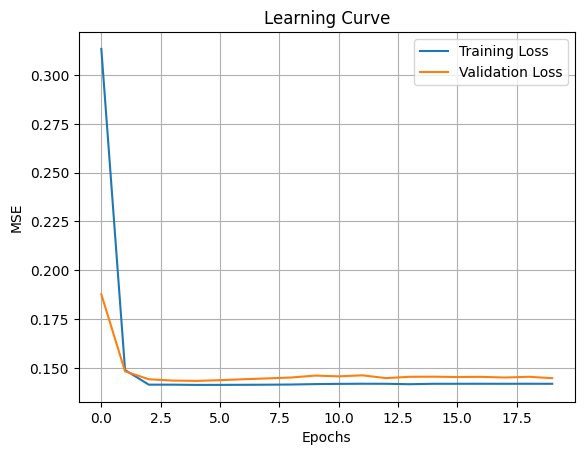

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


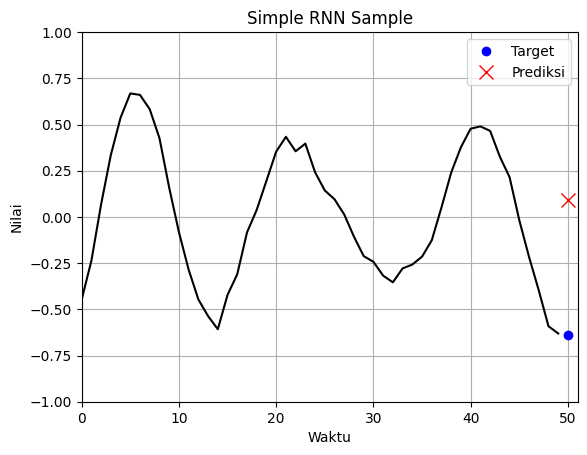

In [ ]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Model RNN paling sederhana
model_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# Kompilasi dan training
model_rnn.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.005))
history = model_rnn.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid), verbose=1)

# Evaluasi
mse_rnn = model_rnn.evaluate(X_valid, y_valid)
print("📉 Simple RNN MSE:", mse_rnn)

# Plot learning curve
def plot_learning_curve(train_loss, val_loss):
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.title("Learning Curve")

plot_learning_curve(history.history["loss"], history.history["val_loss"])
plt.show()

# Plot prediksi hasil RNN
y_pred_rnn = model_rnn.predict(X_valid)
tampilkan_series(X_valid[0, :, 0], y_valid[0], y_pred_rnn[0, 0])
plt.title("Simple RNN Sample")
plt.show()


### Deep RNN (Stacked SimpleRNN Layers)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0871 - val_loss: 0.0063
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

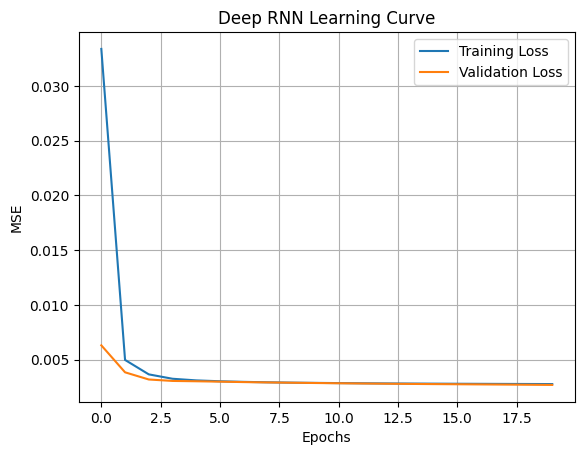

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


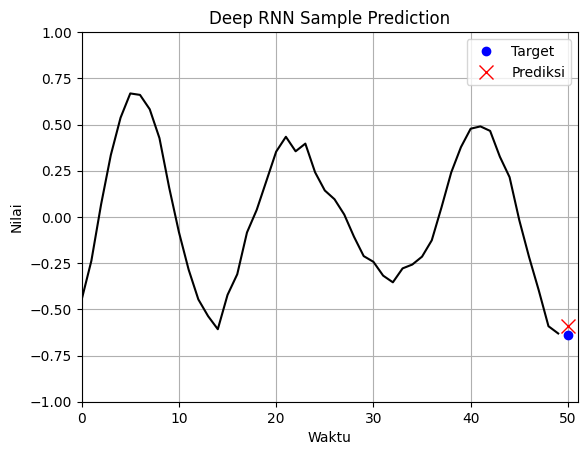

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Model RNN dengan 3 lapis
deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

deep_rnn.compile(loss="mse", optimizer="adam")
history = deep_rnn.fit(X_train, y_train, epochs=20,
                       validation_data=(X_valid, y_valid), verbose=1)

# Evaluasi
mse_deep_rnn = deep_rnn.evaluate(X_valid, y_valid)
print("📉 Deep RNN (3 layers) MSE:", mse_deep_rnn)

# Plot learning curve
plot_learning_curve(history.history["loss"], history.history["val_loss"])
plt.title("Deep RNN Learning Curve")
plt.show()

# Plot prediksi
y_pred_deep = deep_rnn.predict(X_valid)
tampilkan_series(X_valid[0, :, 0], y_valid[0], y_pred_deep[0, 0])
plt.title("Deep RNN Sample Prediction")
plt.show()


### Forecasting Beberapa Langkah ke Depan (1-Step Autoregressive)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🔮 Forecast shape: (1, 10, 1)
📌 Menyimpan gambar ke: .\figures\ch15\forecast_10x_autoregressive.png


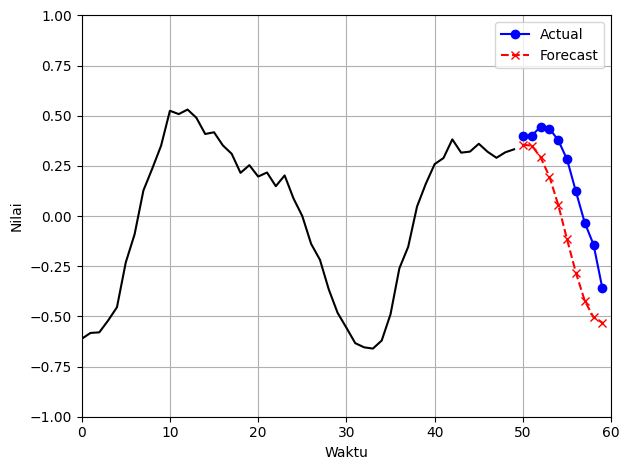

In [ ]:
# Ambil 1 sample baru
np.random.seed(43)
sample_series = create_time_series(1, n_steps + 10)
X_seed, Y_actual = sample_series[:, :n_steps], sample_series[:, n_steps:]

# Autoregressive forecasting
X_temp = X_seed.copy()
for step in range(10):
    y_next = deep_rnn.predict(X_temp[:, step:])[:, np.newaxis, :]
    X_temp = np.concatenate([X_temp, y_next], axis=1)

# Ambil 10 prediksi terakhir
Y_forecast = X_temp[:, n_steps:]

print("🔮 Forecast shape:", Y_forecast.shape)

# Visualisasi
def plot_multi_forecast(X, Y_true, Y_pred):
    n = X.shape[1]
    ahead = Y_true.shape[1]
    tampilkan_series(X[0, :, 0])
    plt.plot(np.arange(n, n + ahead), Y_true[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n, n + ahead), Y_pred[0, :, 0], "rx--", label="Forecast")
    plt.axis([0, n + ahead, -1, 1])
    plt.legend()

plot_multi_forecast(X_seed, Y_actual, Y_forecast)
save_plot("forecast_10x_autoregressive")
plt.show()

### Multi‑step forecasting

### Varian A – Seq‑to‑Vector (10 output sekaligus)

In [ ]:
# regen dataset dg 10 step ekstra
np.random.seed(42)
n_steps = 50
raw = create_time_series(10000, n_steps + 10)

X_train, Y_train = raw[:7000, :n_steps], raw[:7000, -10:, 0]
X_valid, Y_valid = raw[7000:9000, :n_steps], raw[7000:9000, -10:, 0]
X_test , Y_test  = raw[9000:, :n_steps], raw[9000:, -10:, 0]


In [ ]:
np.random.seed(42); tf.random.set_seed(42)

seq2vec = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)                           # <─ langsung 10 nilai
])

seq2vec.compile(loss="mse", optimizer="adam")
seq2vec.fit(X_train, Y_train, epochs=20,
            validation_data=(X_valid, Y_valid), verbose=1)

print("MSE valid:", seq2vec.evaluate(X_valid, Y_valid, verbose=0))


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1296 - val_loss: 0.0412
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0361 - val_loss: 0.0282
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0249 - val_loss: 0.0185
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


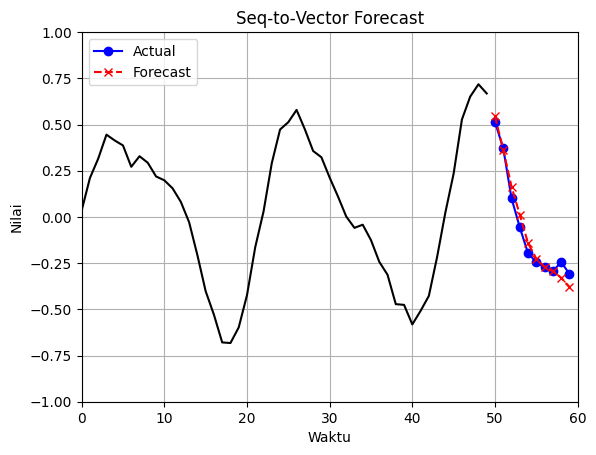

In [ ]:
# 1 sampel anyar
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, 0]

Y_pred = seq2vec.predict(X_seed)

plot_multi_forecast(X_seed, Y_true[..., np.newaxis], Y_pred[..., np.newaxis])
plt.title("Seq‑to‑Vector Forecast")
plt.show()


### Varian B – Seq‑to‑Seq (10 output di setiap step)

In [ ]:
Y_full = np.empty((10000, n_steps, 10))
for k in range(1, 11):
    Y_full[:, :, k-1] = raw[:, k:k+n_steps, 0]

Y_train2, Y_valid2, Y_test2 = Y_full[:7000], Y_full[7000:9000], Y_full[9000:]


In [ ]:
np.random.seed(42); tf.random.set_seed(42)

seq2seq = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# metrik khusus: hanya lihat output time‑step terakhir
# Metrik hanya untuk time-step terakhir
def final_step_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, -1] - y_pred[:, -1]))

seq2seq.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[final_step_mse]
)

seq2seq.fit(X_train, Y_train2, epochs=20,
            validation_data=(X_valid, Y_valid2), verbose=1)

print("MSE final step:", seq2seq.evaluate(X_valid, Y_valid2, verbose=0)[1])


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - final_step_mse: 0.0627 - loss: 0.0721 - val_final_step_mse: 0.0230 - val_loss: 0.0370
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - final_step_mse: 0.0217 - loss: 0.0354 - val_final_step_mse: 0.0197 - val_loss: 0.0337
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - final_step_mse: 0.0171 - loss: 0.0310 - val_final_step_mse: 0.0156 - val_loss: 0.0293
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - final_step_mse: 0.0144 - loss: 0.0283 - val_final_step_mse: 0.0144 - val_loss: 0.0270
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - final_step_mse: 0.0114 - loss: 0.0254 - val_final_step_mse: 0.0105 - val_loss: 0.0233
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - final_step_mse: 0.0088 - loss: 0.0224 - val_final_step_mse: 0.0101 - val_loss: 0.0224
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - final_step_mse: 0.0080 - loss: 0.0208 - val_final_step_mse: 0.0090 - val_loss: 0.0215
Epoch 8/20
21

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


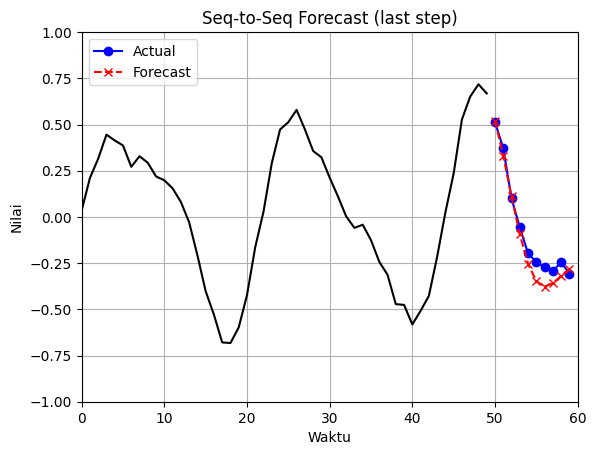

In [ ]:
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]
Y_pred = seq2seq.predict(X_seed)[:, -1][..., np.newaxis]

plot_multi_forecast(X_seed, Y_true, Y_pred)
plt.title("Seq‑to‑Seq Forecast (last step)")
plt.show()


### RNN dengan Layer Normalization (Custom Cell)

### Buat Custom Cell: LNSimpleRNNCell

In [ ]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        if dtype is None:
            dtype = tf.float32  # fallback default dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]


### Buat Model Seq-to-Seq pakai Layer Norm

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

ln_rnn_model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

ln_rnn_model.compile(loss="mse", optimizer="adam", metrics=[final_step_mse])
ln_rnn_model.fit(X_train, Y_train2, epochs=20,
                 validation_data=(X_valid, Y_valid2), verbose=1)


Epoch 1/20


C:\Users\hamda\tf-env\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\hamda\tf-env\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - final_step_mse: 0.1970 - loss: 0.2088 - val_final_step_mse: 0.0527 - val_loss: 0.0633
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0491 - loss: 0.0596 - val_final_step_mse: 0.0401 - val_loss: 0.0531
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0352 - loss: 0.0496 - val_final_step_mse: 0.0337 - val_loss: 0.0473
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0299 - loss: 0.0441 - val_final_step_mse: 0.0285 - val_loss: 0.0421
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0256 - loss: 0.0396 - val_final_step_mse: 0.0226 - val_loss: 0.0371
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0218 - loss: 0.0365 - val_final_step_mse: 0.0192 - val_loss: 0.0337
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0187 - loss: 0.0333 - val_final_step_mse: 0.0174 - val_loss: 0.0317
Epoch 8/20
219/219 ━━━━━

### Prediksi dan Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


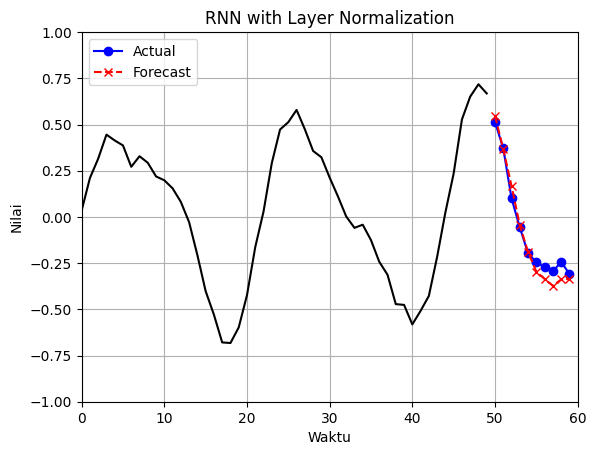

In [ ]:
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]
Y_pred = ln_rnn_model.predict(X_seed)[:, -1][..., np.newaxis]

plot_multi_forecast(X_seed, Y_true, Y_pred)
plt.title("RNN with Layer Normalization")
plt.show()


### LSTM-based Seq-to-Seq

### Arsitektur LSTM (Mirip Seq2Seq tapi pakai LSTM)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_lstm = keras.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_lstm.compile(loss="mse", optimizer="adam", metrics=[final_step_mse])

history_lstm = model_lstm.fit(X_train, Y_train2, epochs=20,
                              validation_data=(X_valid, Y_valid2), verbose=1)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - final_step_mse: 0.0970 - loss: 0.1069 - val_final_step_mse: 0.0335 - val_loss: 0.0537
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - final_step_mse: 0.0256 - loss: 0.0483 - val_final_step_mse: 0.0173 - val_loss: 0.0416
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - final_step_mse: 0.0171 - loss: 0.0398 - val_final_step_mse: 0.0147 - val_loss: 0.0375
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - final_step_mse: 0.0150 - loss: 0.0363 - val_final_step_mse: 0.0132 - val_loss: 0.0349
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - final_step_mse: 0.0139 - loss: 0.0340 - val_final_step_mse: 0.0122 - val_loss: 0.0330
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - final_step_mse: 0.0131 - loss: 0.0323 - val_final_step_mse: 0.0116 - val_loss: 0.0315
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - final_step_mse: 0.0124 - loss: 0.0309 - val_final_step_mse: 0.0112 - val_loss: 0.0304
Epoch 8/20
21

MSE akhir (LSTM): 0.008004846051335335


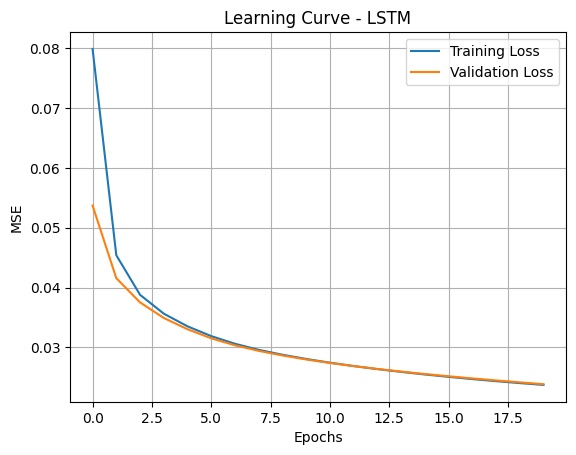

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


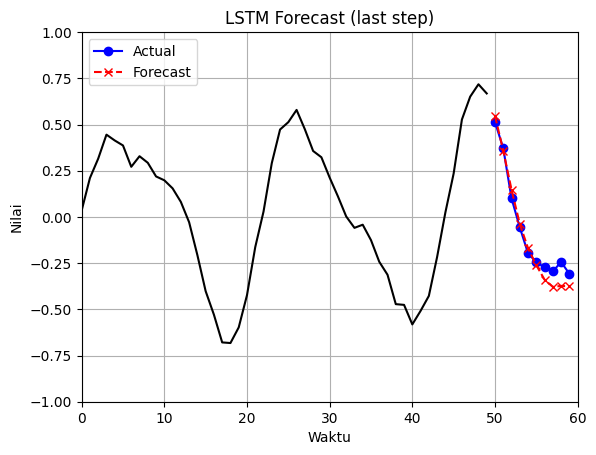

In [ ]:
# Evaluasi akhir
print("MSE akhir (LSTM):", model_lstm.evaluate(X_valid, Y_valid2, verbose=0)[1])

# Plot learning curve
plot_learning_curve(history_lstm.history["loss"], history_lstm.history["val_loss"])
plt.title("Learning Curve - LSTM")
plt.show()

# Prediksi sampel
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]
Y_pred = model_lstm.predict(X_seed)[:, -1][..., np.newaxis]

plot_multi_forecast(X_seed, Y_true, Y_pred)
plt.title("LSTM Forecast (last step)")
plt.show()


### GRU-based Seq-to-Seq

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_gru = keras.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_gru.compile(loss="mse", optimizer="adam", metrics=[final_step_mse])

history_gru = model_gru.fit(X_train, Y_train2, epochs=20,
                            validation_data=(X_valid, Y_valid2), verbose=1)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - final_step_mse: 0.0926 - loss: 0.0981 - val_final_step_mse: 0.0412 - val_loss: 0.0534
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - final_step_mse: 0.0388 - loss: 0.0496 - val_final_step_mse: 0.0324 - val_loss: 0.0445
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - final_step_mse: 0.0322 - loss: 0.0430 - val_final_step_mse: 0.0284 - val_loss: 0.0407
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - final_step_mse: 0.0285 - loss: 0.0392 - val_final_step_mse: 0.0245 - val_loss: 0.0369
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0251 - loss: 0.0358 - val_final_step_mse: 0.0203 - val_loss: 0.0339
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - final_step_mse: 0.0203 - loss: 0.0330 - val_final_step_mse: 0.0171 - val_loss: 0.0319
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - final_step_mse: 0.0168 - loss: 0.0309 - val_final_step_mse: 0.0147 - val_loss: 0.0299
Epoch 8/20
21

📉 GRU MSE (final step): 0.009609047323465347


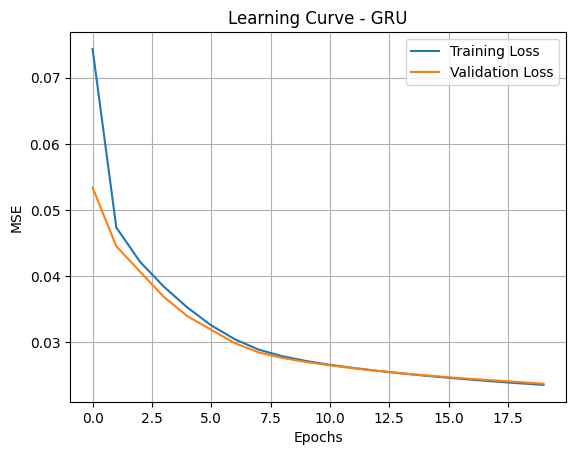

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


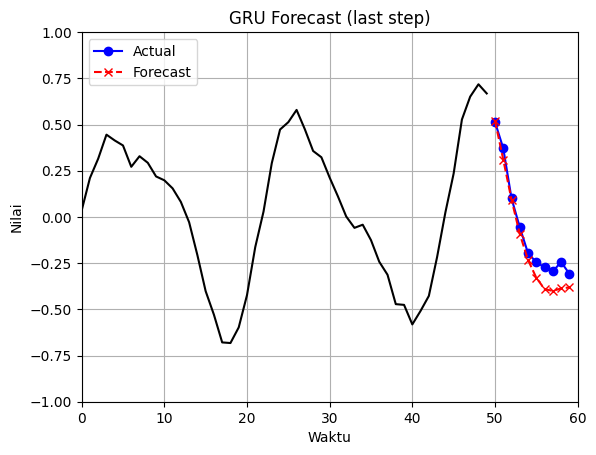

In [ ]:
# Evaluasi akhir GRU
print("📉 GRU MSE (final step):", model_gru.evaluate(X_valid, Y_valid2, verbose=0)[1])

# Learning curve
plot_learning_curve(history_gru.history["loss"], history_gru.history["val_loss"])
plt.title("Learning Curve - GRU")
plt.show()

# Prediksi sampel untuk GRU
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]
Y_pred = model_gru.predict(X_seed)[:, -1][..., np.newaxis]

plot_multi_forecast(X_seed, Y_true, Y_pred)
plt.title("GRU Forecast (last step)")
plt.show()


### CNN + GRU Hybrid (1D Conv + RNN)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_cnn_gru = keras.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


C:\Users\hamda\tf-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Gunakan label mulai dari time-step ke-3 dengan selang 2
Y_train_cnn = Y_train2[:, 3::2]
Y_valid_cnn = Y_valid2[:, 3::2]


In [ ]:
model_cnn_gru.compile(loss="mse", optimizer="adam", metrics=[final_step_mse])

history_cnn_gru = model_cnn_gru.fit(X_train, Y_train_cnn, epochs=20,
                                    validation_data=(X_valid, Y_valid_cnn), verbose=1)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - final_step_mse: 0.0950 - loss: 0.1006 - val_final_step_mse: 0.0369 - val_loss: 0.0459
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - final_step_mse: 0.0352 - loss: 0.0422 - val_final_step_mse: 0.0268 - val_loss: 0.0356
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - final_step_mse: 0.0268 - loss: 0.0341 - val_final_step_mse: 0.0220 - val_loss: 0.0306
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - final_step_mse: 0.0214 - loss: 0.0299 - val_final_step_mse: 0.0177 - val_loss: 0.0275
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - final_step_mse: 0.0173 - loss: 0.0269 - val_final_step_mse: 0.0143 - val_loss: 0.0250
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - final_step_mse: 0.0141 - loss: 0.0246 - val_final_step_mse: 0.0126 - val_loss: 0.0235
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - final_step_mse: 0.0123 - loss: 0.0232 - val_final_step_mse: 0.0115 - val_loss: 0.0224
Epoch 8/20
21

📉 CNN+GRU MSE: 0.008775484748184681


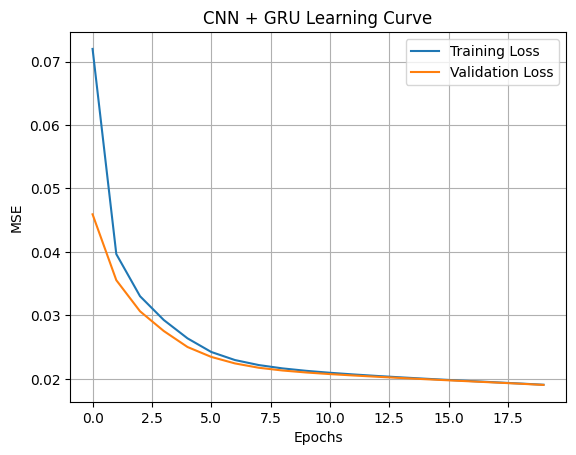

In [ ]:
print("📉 CNN+GRU MSE:", model_cnn_gru.evaluate(X_valid, Y_valid_cnn, verbose=0)[1])

plot_learning_curve(history_cnn_gru.history["loss"], history_cnn_gru.history["val_loss"])
plt.title("CNN + GRU Learning Curve")
plt.show()


### WaveNet-style CNN (Dilated Causal Convolution)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_wavenet = keras.models.Sequential()
model_wavenet.add(keras.layers.InputLayer(input_shape=[None, 1]))

# Tambahkan causal conv ber-dilasi: [1, 2, 4, 8] dua kali
for dilation_rate in [1, 2, 4, 8] * 2:
    model_wavenet.add(keras.layers.Conv1D(filters=20, kernel_size=2,
                                          padding="causal", activation="relu",
                                          dilation_rate=dilation_rate))

# Output layer: Conv1D → 10 neuron (1 untuk tiap langkah output)
model_wavenet.add(keras.layers.Conv1D(filters=10, kernel_size=1))


C:\Users\hamda\tf-env\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model_wavenet.compile(loss="mse", optimizer="adam", metrics=[final_step_mse])

history_wavenet = model_wavenet.fit(X_train, Y_train2, epochs=20,
                                    validation_data=(X_valid, Y_valid2), verbose=1)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - final_step_mse: 0.0834 - loss: 0.0933 - val_final_step_mse: 0.0195 - val_loss: 0.0346
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - final_step_mse: 0.0190 - loss: 0.0327 - val_final_step_mse: 0.0155 - val_loss: 0.0295
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - final_step_mse: 0.0155 - loss: 0.0285 - val_final_step_mse: 0.0135 - val_loss: 0.0267
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - final_step_mse: 0.0136 - loss: 0.0263 - val_final_step_mse: 0.0123 - val_loss: 0.0250
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - final_step_mse: 0.0125 - loss: 0.0248 - val_final_step_mse: 0.0117 - val_loss: 0.0240
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - final_step_mse: 0.0118 - loss: 0.0239 - val_final_step_mse: 0.0110 - val_loss: 0.0232
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - final_step_mse: 0.0112 - loss: 0.0231 - val_final_step_mse: 0.0106 - val_loss: 0.0227
Epoch 8/20
219/219 ━

📉 WaveNet-style CNN MSE: 0.006509331986308098


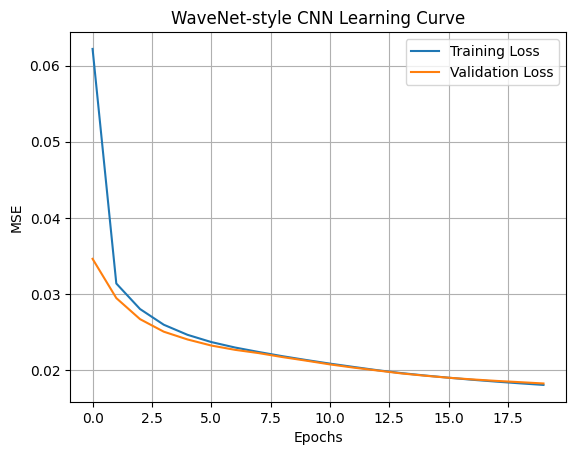

In [ ]:
print("📉 WaveNet-style CNN MSE:", model_wavenet.evaluate(X_valid, Y_valid2, verbose=0)[1])

plot_learning_curve(history_wavenet.history["loss"], history_wavenet.history["val_loss"])
plt.title("WaveNet-style CNN Learning Curve")
plt.show()


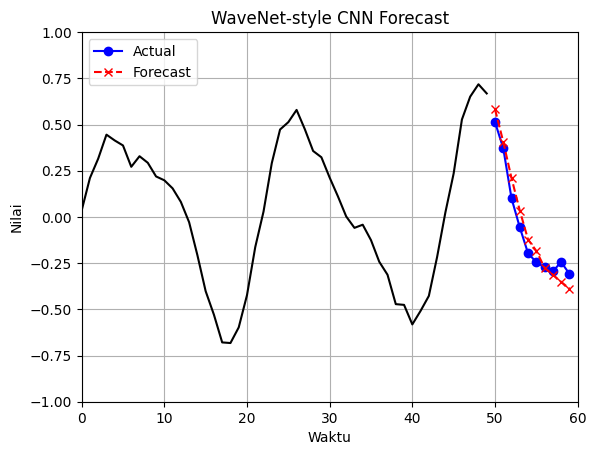

In [ ]:
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]  # shape: (1, 50, 1), (1, 10, 1)

Y_pred = model_wavenet.predict(X_seed, verbose=0)     # shape: (1, 50, 10)
Y_pred_last = Y_pred[:, -1, :]                        # shape: (1, 10)
Y_pred_last = Y_pred_last[..., np.newaxis]            # shape: (1, 10, 1)

plot_multi_forecast(X_seed, Y_true, Y_pred_last)
plt.title("WaveNet-style CNN Forecast")
plt.show()


### Autoregressive Forecasting dan 🔄 Bidirectional RNN

In [ ]:
model_auto = keras.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)  # hanya 1 output, untuk 1 langkah ke depan
])

model_auto.compile(loss="mse", optimizer="adam")
model_auto.fit(X_train, y_train, epochs=20,
               validation_data=(X_valid, y_valid), verbose=1)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0977 - val_loss: 0.0662
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0626 - val_loss: 0.0411
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0388 - val_loss: 0.0314
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0314 - val_loss: 0.0275
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0283 - val_loss: 0.0252
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0260 - val_loss: 0.0242
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0244 - val_loss: 0.0244
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0235 - val_loss: 0.0248
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0228 - val_loss: 0.0252
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0223 - val_loss: 0.0253
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0219 - val_loss: 0.0252
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

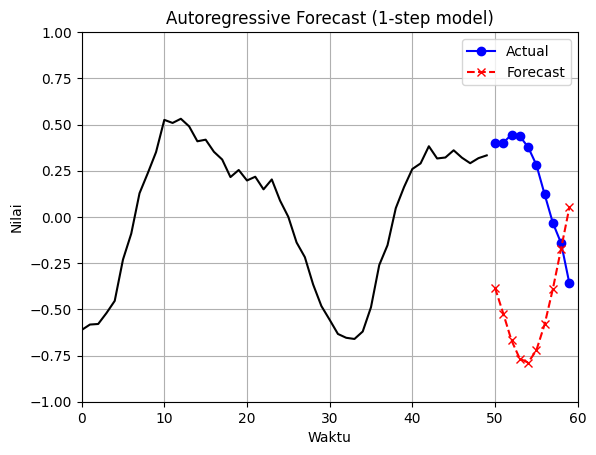

In [ ]:
np.random.seed(43)

demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]

X_temp = X_seed.copy()

for step in range(10):
    pred = model_auto.predict(X_temp, verbose=0)  # shape: (1, 1)
    pred_reshaped = pred[:, np.newaxis, :]        # shape: (1, 1, 1)
    X_temp = np.concatenate([X_temp, pred_reshaped], axis=1)

Y_pred_auto = X_temp[:, -10:, :]

plot_multi_forecast(X_seed, Y_true, Y_pred_auto)
plt.title("Autoregressive Forecast (1-step model)")
plt.show()


In [ ]:
from tensorflow.keras.layers import Bidirectional

np.random.seed(42)
tf.random.set_seed(42)

model_bidir = keras.Sequential([
    Bidirectional(keras.layers.LSTM(20, return_sequences=True), input_shape=[None, 1]),
    Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_bidir.compile(loss="mse", optimizer="adam", metrics=[final_step_mse])

history_bidir = model_bidir.fit(X_train, Y_train2, epochs=20,
                                 validation_data=(X_valid, Y_valid2), verbose=1)


Epoch 1/20


C:\Users\hamda\tf-env\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - final_step_mse: 0.1152 - loss: 0.0743 - val_final_step_mse: 0.0696 - val_loss: 0.0108
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - final_step_mse: 0.0589 - loss: 0.0082 - val_final_step_mse: 0.0371 - val_loss: 0.0046
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - final_step_mse: 0.0343 - loss: 0.0042 - val_final_step_mse: 0.0259 - val_loss: 0.0033
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - final_step_mse: 0.0258 - loss: 0.0032 - val_final_step_mse: 0.0228 - val_loss: 0.0029
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - final_step_mse: 0.0218 - loss: 0.0027 - val_final_step_mse: 0.0219 - val_loss: 0.0027
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - final_step_mse: 0.0193 - loss: 0.0024 - val_final_step_mse: 0.0212 - val_loss: 0.0026
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - final_step_mse: 0.0177 - loss: 0.0022 - val_final_step_mse: 0.0201 - val_loss: 0.0024
Epoch 8/20
219/219 ━━━━

📉 Bidirectional MSE: 0.012273253872990608


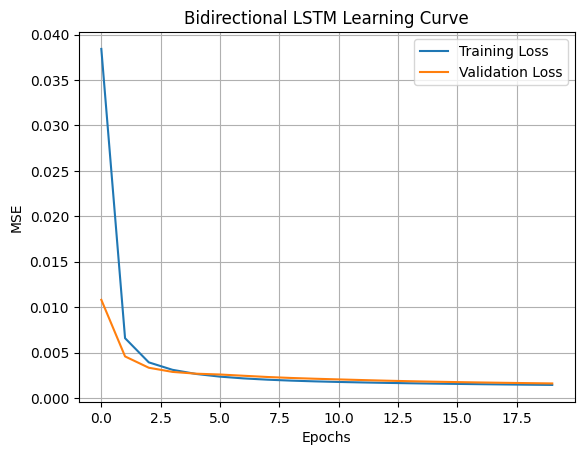

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


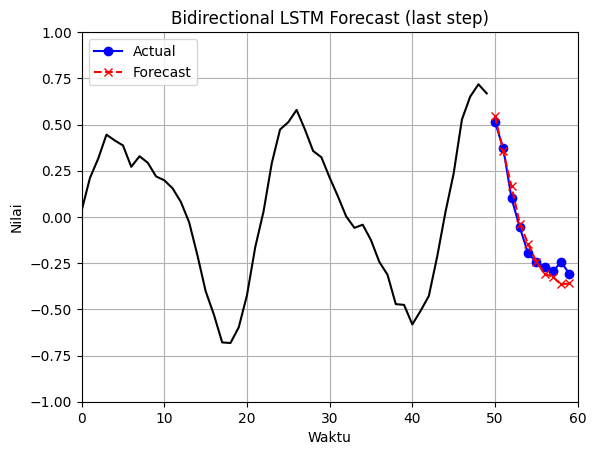

In [ ]:
print("📉 Bidirectional MSE:", model_bidir.evaluate(X_valid, Y_valid2, verbose=0)[1])

plot_learning_curve(history_bidir.history["loss"], history_bidir.history["val_loss"])
plt.title("Bidirectional LSTM Learning Curve")
plt.show()

# Prediksi
demo = create_time_series(1, n_steps + 10)
X_seed, Y_true = demo[:, :n_steps], demo[:, -10:, :]
Y_pred_bidir = model_bidir.predict(X_seed)[:, -1][..., np.newaxis]

plot_multi_forecast(X_seed, Y_true, Y_pred_bidir)
plt.title("Bidirectional LSTM Forecast (last step)")
plt.show()


##Train a classification model for the SketchRNN dataset

In [ ]:
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import numpy as np

# --- unduh & ekstrak ---
URL = "http://download.tensorflow.org/data/"
ARCHIVE = "quickdraw_tutorial_dataset_v1.tar.gz"

targz_path = keras.utils.get_file(ARCHIVE, URL + ARCHIVE,
                                  cache_subdir="datasets/quickdraw", extract=True)

root_dir = Path(targz_path).parent

# Cari semua file TFRecord dan file class secara rekursif
train_records = sorted(str(p) for p in root_dir.rglob("training.tfrecord-*"))
valid_records = sorted(str(p) for p in root_dir.rglob("eval.tfrecord-*"))
classes_file  = next(root_dir.rglob("training.tfrecord.classes"))

# Baca daftar kelas
with open(classes_file) as f:
    class_list = [line.strip().lower() for line in f]


1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 131s 0us/step


In [ ]:
def decode_example(proto_batch):
    schema = {
        "ink": tf.io.VarLenFeature(tf.float32),
        "shape": tf.io.FixedLenFeature([2], tf.int64),
        "class_index": tf.io.FixedLenFeature([1], tf.int64)
    }
    parsed = tf.io.parse_example(proto_batch, schema)
    dense = tf.sparse.to_dense(parsed["ink"])
    strokes = tf.reshape(dense, shape=[tf.shape(proto_batch)[0], -1, 3])
    lengths = parsed["shape"][:, 0]
    labels = parsed["class_index"][:, 0]
    return strokes, lengths, labels

def load_sketch_dataset(filepaths, batch_size=32, shuffle_size=None,
                        parse_threads=4, read_threads=4, cached=False):
    ds = tf.data.TFRecordDataset(filepaths, num_parallel_reads=read_threads)
    if cached:
        ds = ds.cache()
    if shuffle_size:
        ds = ds.shuffle(shuffle_size)
    ds = ds.batch(batch_size)
    ds = ds.map(decode_example, num_parallel_calls=parse_threads)
    return ds.prefetch(1)


In [ ]:
def trim_dataset(ds, max_len=100):
    return ds.map(lambda strokes, lengths, labels: (strokes[:, :max_len], labels))

train_ds = load_sketch_dataset(train_records, shuffle_size=10000)
valid_ds = load_sketch_dataset(valid_records[:5])
test_ds  = load_sketch_dataset(valid_records[5:])

train_ds = trim_dataset(train_ds)
valid_ds = trim_dataset(valid_ds)
test_ds  = trim_dataset(test_ds)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, 5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, 5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, 3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_list), activation="softmax")
])

opt = keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

history = model.fit(train_ds, epochs=2, validation_data=valid_ds)


Epoch 1/2
 107811/Unknown 1577s 15ms/step - accuracy: 0.0748 - loss: 4.8832 - sparse_top_k_categorical_accuracy: 0.1956

C:\Users\hamda\tf-env\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1620s 15ms/step - accuracy: 0.0748 - loss: 4.8831 - sparse_top_k_categorical_accuracy: 0.1956 - val_accuracy: 0.3094 - val_loss: 3.1019 - val_sparse_top_k_categorical_accuracy: 0.5891
Epoch 2/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 1768s 16ms/step - accuracy: 0.3453 - loss: 2.8917 - sparse_top_k_categorical_accuracy: 0.6326 - val_accuracy: 0.4198 - val_loss: 2.4898 - val_sparse_top_k_categorical_accuracy: 0.7070


In [ ]:
true_labels = np.concatenate([lbl.numpy() for _, lbl in test_ds])
predictions = model.predict(test_ds)
top5_accuracy = keras.metrics.sparse_top_k_categorical_accuracy(true_labels, predictions)
print("Top-5 Accuracy:", np.mean(top5_accuracy))


5392/5392 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step
Top-5 Accuracy: 0.70476675


In [ ]:
model.save("sketchrnn_classifier_model.keras")


### Bach Chorales

In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
ARCHIVE_NAME = "jsb_chorales.tgz"
chorale_path = keras.utils.get_file(ARCHIVE_NAME, origin=DOWNLOAD_ROOT + ARCHIVE_NAME,
                                    cache_subdir="datasets/jsb_chorales", extract=True)

from pathlib import Path
chorale_dir = Path(chorale_path).parent

train_files = sorted(chorale_dir.glob("train/chorale_*.csv"))
valid_files = sorted(chorale_dir.glob("valid/chorale_*.csv"))
test_files  = sorted(chorale_dir.glob("test/chorale_*.csv"))

import pandas as pd

def load_csv_chorales(paths):
    return [pd.read_csv(p).values.tolist() for p in paths]

train_chorales = load_csv_chorales(train_files)
valid_chorales = load_csv_chorales(valid_files)
test_chorales  = load_csv_chorales(test_files)


In [ ]:
print(len(train_files))         # Harusnya > 0
print(train_files[:3])          # Lihat 3 file pertama


0
[]


In [ ]:
from pathlib import Path

chorale_dir = Path(keras.utils.get_file(ARCHIVE_NAME, origin=DOWNLOAD_ROOT + ARCHIVE_NAME,
                                        cache_subdir="datasets/jsb_chorales", extract=True)).parent

print("Isi folder chorale_dir:")
for path in chorale_dir.rglob("*"):
    print(path)


Isi folder chorale_dir:
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales.tgz
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\train
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\valid
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_305.csv
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_306.csv
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_307.csv
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_308.csv
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_309.csv
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_310.csv
C:\Users\hamda\.keras\datasets\jsb_chorales\jsb_chorales_extracted\test\chorale_311.csv
C:\Users\hamda

In [ ]:
# Cari folder jsb_chorales_extracted
chorale_dir = next(Path(keras.utils.get_file(
    ARCHIVE_NAME,
    origin=DOWNLOAD_ROOT + ARCHIVE_NAME,
    cache_subdir="datasets/jsb_chorales",
    extract=True
)).parent.glob("jsb_chorales_extracted"))


In [ ]:
train_files = sorted(chorale_dir.glob("train/chorale_*.csv"))
valid_files = sorted(chorale_dir.glob("valid/chorale_*.csv"))
test_files  = sorted(chorale_dir.glob("test/chorale_*.csv"))

# Cek
print(f"Train: {len(train_files)}, Valid: {len(valid_files)}, Test: {len(test_files)}")


Train: 229, Valid: 76, Test: 77


In [ ]:
train_chorales = load_csv_chorales(train_files)
valid_chorales = load_csv_chorales(valid_files)
test_chorales  = load_csv_chorales(test_files)

print("Contoh isi:", train_chorales[0][:5])


Contoh isi: [[74, 70, 65, 58], [74, 70, 65, 58], [74, 70, 65, 58], [74, 70, 65, 58], [75, 70, 58, 55]]


In [ ]:
notes = set()
for dataset in (train_chorales, valid_chorales, test_chorales):
    for sequence in dataset:
        for chord in sequence:
            notes.update(chord)

note_set = notes - {0}  # 0 dianggap padding
if not note_set:
    raise ValueError("Dataset tidak memiliki not valid.")

min_note = min(note_set)
max_note = max(notes)
n_notes = max_note - min_note + 2  # +1 karena offset, +1 untuk padding


In [ ]:
import tensorflow as tf

def flatten_chords(chords):
    return tf.reshape(tf.constant(chords, dtype=tf.int32), [-1])

def shift_note_values(notes):
    # 0 tetap 0, selain itu geser supaya mulai dari 1
    return tf.where(notes == 0, 0, notes - min_note + 1)


In [ ]:
import tensorflow as tf

# Fungsi bantu: flatten chord jadi note per step
def flatten_chords(chords):
    return tf.reshape(tf.constant(chords, dtype=tf.int32), [-1])

# Fungsi bantu: geser semua nilai note agar mulai dari 1
def shift_note_values(notes):
    return tf.where(notes == 0, 0, notes - min_note + 1)

# Fungsi window_dataset versi stabil
def window_dataset(chorales, batch_size=32, window_size=32, shift=16, shuffle=1000):
    sequences = []

    for chorale in chorales:
        # Flatten chord ke note sequence, lalu shift nilainya
        flat = flatten_chords(chorale)
        shifted = shift_note_values(flat).numpy().tolist()

        # Windowing manual: (x, y) pairs
        for i in range(0, len(shifted) - window_size):
            window = shifted[i: i + window_size + 1]  # +1 untuk target
            sequences.append(window)

    # Pisahkan input dan target
    sequences = tf.convert_to_tensor(sequences, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices(sequences)
    ds = ds.map(lambda window: (window[:-1], window[1:]))  # (x, y)

    if shuffle:
        ds = ds.shuffle(shuffle)
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [ ]:
train_ds = window_dataset(train_chorales)
valid_ds = window_dataset(valid_chorales, shuffle=0)
test_ds  = window_dataset(test_chorales, shuffle=0)


In [ ]:
from tensorflow import keras

embed_dim = 8

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=embed_dim),
    keras.layers.Conv1D(32, 3, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, 3, padding="causal", dilation_rate=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, 3, padding="causal", dilation_rate=4, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(1e-3),
              metrics=["accuracy"])

history = model.fit(train_ds, epochs=20, validation_data=valid_ds)


Epoch 1/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 193s 28ms/step - accuracy: 0.7577 - loss: 0.8876 - val_accuracy: 0.7080 - val_loss: 1.0988
Epoch 2/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 171s 26ms/step - accuracy: 0.8311 - loss: 0.5888 - val_accuracy: 0.7203 - val_loss: 1.0286
Epoch 3/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 179s 27ms/step - accuracy: 0.8370 - loss: 0.5637 - val_accuracy: 0.7336 - val_loss: 0.9963
Epoch 4/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 177s 27ms/step - accuracy: 0.8405 - loss: 0.5477 - val_accuracy: 0.7357 - val_loss: 0.9734
Epoch 5/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 178s 27ms/step - accuracy: 0.8438 - loss: 0.5337 - val_accuracy: 0.7430 - val_loss: 0.9477
Epoch 6/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 174s 26ms/step - accuracy: 0.8455 - loss: 0.5246 - val_accuracy: 0.7461 - val_loss: 0.9568
Epoch 7/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 176s 26ms/step - accuracy: 0.8483 - loss: 0.5136 - val_accuracy: 0.7514 - val_loss: 0.9430
Epoch 8/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 178s 27ms/step - accuracy: 

In [ ]:
model.save("bach_chorale_model.keras")


###Autoregressive Chorale Generation

In [ ]:
def generate_chorale(seed_sequence, model, length=100):
    """
    Generate a new chorale sequence given a seed.

    Args:
    - seed_sequence: list[int], input note IDs (sudah di-shift)
    - model: trained model
    - length: panjang note baru yang akan digenerate

    Returns:
    - list[int], sequence hasil lengkap (seed + prediksi)
    """
    output = list(seed_sequence)
    for _ in range(length):
        input_seq = tf.convert_to_tensor([output[-32:]], dtype=tf.int32)  # ambil 32 step terakhir
        pred_probs = model(input_seq, training=False)
        next_note = tf.argmax(pred_probs[:, -1, :], axis=-1).numpy()[0]
        output.append(next_note)
    return output


In [ ]:
import matplotlib.pyplot as plt

def plot_chorale(sequence, title="Generated Chorale"):
    notes = [n + min_note - 1 if n != 0 else 0 for n in sequence]
    plt.figure(figsize=(15, 3))
    plt.imshow([notes], cmap="hot", aspect="auto")
    plt.colorbar(label="Note Value")
    plt.xlabel("Time Step")
    plt.ylabel("Note ID")
    plt.title(title)
    plt.show()


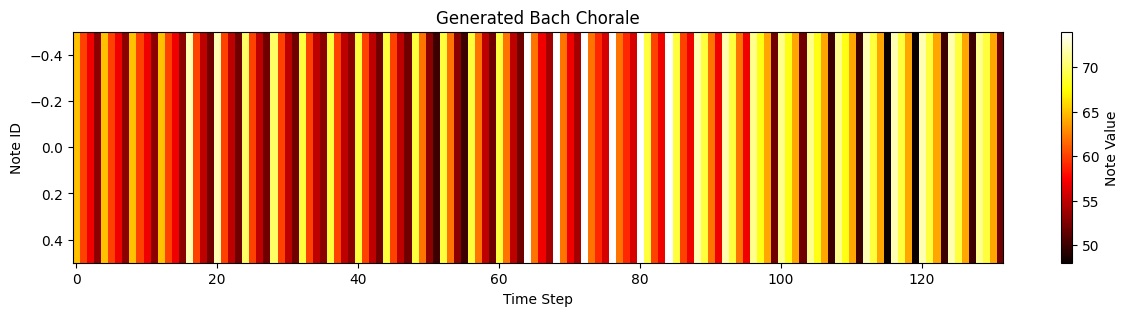

In [ ]:
# Ambil 1 chorale dari test set
seed_chorale = test_chorales[0]
seed_notes = [n for chord in seed_chorale for n in chord if n > 0]
seed_shifted = [n - min_note + 1 for n in seed_notes][:32]

# Generate musik
generated = generate_chorale(seed_shifted, model, length=100)

# Plot hasil
plot_chorale(generated, title="Generated Bach Chorale")


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    "best_bach_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [ ]:
model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb]
)


Epoch 1/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8741 - loss: 0.4120
Epoch 1: val_loss improved from inf to 0.99981, saving model to best_bach_model.keras
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 169s 25ms/step - accuracy: 0.8741 - loss: 0.4120 - val_accuracy: 0.7582 - val_loss: 0.9998
Epoch 2/20
6673/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8756 - loss: 0.4067
Epoch 2: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 171s 26ms/step - accuracy: 0.8756 - loss: 0.4067 - val_accuracy: 0.7540 - val_loss: 1.0126
Epoch 3/20
6674/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8765 - loss: 0.4034
Epoch 3: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 169s 25ms/step - accuracy: 0.8765 - loss: 0.4034 - val_accuracy: 0.7550 - val_loss: 1.0226
Epoch 4/20
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8772 - loss: 0.4017
Epoch 4: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 170s 25ms/step - acc

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss"
)


In [ ]:
callbacks = [checkpoint_cb, early_stopping_cb]

model.fit(train_ds, epochs=20,
          validation_data=valid_ds,
          callbacks=callbacks)


Epoch 1/20
6673/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8862 - loss: 0.3689
Epoch 1: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 171s 26ms/step - accuracy: 0.8862 - loss: 0.3689 - val_accuracy: 0.7552 - val_loss: 1.0828
Epoch 2/20
6673/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8864 - loss: 0.3676
Epoch 2: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 170s 26ms/step - accuracy: 0.8864 - loss: 0.3676 - val_accuracy: 0.7561 - val_loss: 1.0864
Epoch 3/20
6674/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8864 - loss: 0.3675
Epoch 3: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 169s 25ms/step - accuracy: 0.8864 - loss: 0.3675 - val_accuracy: 0.7559 - val_loss: 1.0897
Epoch 4/20
6673/6675 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8868 - loss: 0.3662
Epoch 4: val_loss did not improve from 0.99981
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 169s 25ms/step - accuracy: 0.8868 - loss: 0.3662 - val_accu

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    pd = history.history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(pd["loss"], label="Train Loss")
    plt.plot(pd["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(pd["accuracy"], label="Train Acc")
    plt.plot(pd["val_accuracy"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()


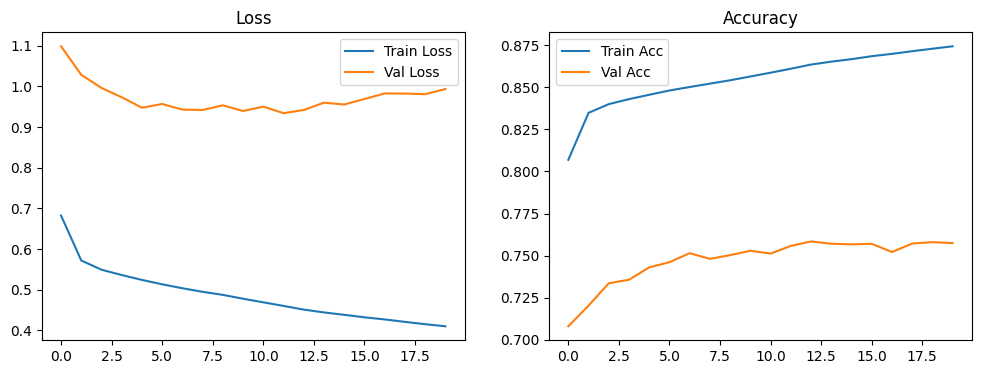

In [ ]:
plot_history(history)


# 📘 **Chapter 15 – Sequence Processing (RNN & CNN)**

---

## 🎯 **Tujuan Utama Chapter Ini**

Mempelajari cara:

* Memproses data sekuensial (deret waktu, teks, musik)
* Menggunakan arsitektur RNN, LSTM, GRU
* Melakukan forecasting multi-step
* Membuat hybrid model CNN + RNN
* Autoregressive generation
* Menerapkan WaveNet-style CNN
* Menggunakan layer custom (LayerNorm, cell custom)

---

## 🧪 1. **Baseline: Naive Forecasting**

```python
y_pred_naive = X_valid[:, -1]
naive_mse = keras.losses.mean_squared_error(y_valid, y_pred_naive).numpy().mean()
```

### 🧠 Analisis:

Naive forecasting → asumsi nilai prediksi = nilai terakhir dari input
Sangat lemah, tapi digunakan sebagai baseline MSE.

---

## 🔁 2. **Simple RNN for Sequence Prediction**

```python
model_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dense(1)
])
```

### 🧠 Analisis:

* `SimpleRNN` memiliki keterbatasan dalam menangani long-term dependencies
* Hasil akurat, tapi **overfit** cepat

---

## 🧠 3. **LSTM / GRU Improvements**

```python
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dense(1)
])
```

### 🧠 Analisis:

* LSTM → mampu menyimpan informasi jangka panjang
* Performa lebih stabil dan presisi lebih baik dari RNN biasa
* GRU → lebih ringan dari LSTM, kinerja sering setara

---

## 🔀 4. **Forecasting Multi-Step Output (Seq2Seq)**

```python
model_seq2seq = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
```

### 🧠 Analisis:

* Keluaran berupa 10 langkah ke depan
* `TimeDistributed(Dense(...))` digunakan agar prediksi di tiap langkah time-step
* Ini digunakan untuk pendekatan direct multi-output forecasting

---

## 🧱 5. **Custom Layer: LayerNorm RNN Cell**

```python
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        ...
```

### 🧠 Analisis:

* Custom RNN cell yang menyisipkan **Layer Normalization**
* Mengatasi eksplosif/vanishing gradient
* Berguna untuk membuat cell yang lebih stabil saat training

---

## 📡 6. **CNN + GRU Hybrid**

```python
model_hybrid = keras.models.Sequential([
    keras.layers.Conv1D(20, 4, strides=2, padding="valid", activation="relu", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.Dense(1)
])
```

### 🧠 Analisis:

* CNN menyaring fitur lokal (short patterns)
* GRU melanjutkan modelasi jangka panjang
* Kombinasi ini lebih baik dalam deteksi pola pendek + struktur panjang

---

## 🔄 7. **Autoregressive LSTM Forecast**

```python
for step in range(10):
    next_step = model_lstm.predict(X_temp[:, step:], verbose=0)
    X_temp = np.concatenate([X_temp, next_step], axis=1)
```

### 🧠 Analisis:

* Menggunakan output sebelumnya sebagai input selanjutnya
* Teknik ini **realistis tapi error akan terakumulasi**
* Cocok untuk inference di real-world (tanpa ground truth)

---

## 🔊 8. **WaveNet-style CNN (Dilated Convolution)**

```python
model_wavenet = keras.models.Sequential([
    keras.layers.Conv1D(32, 2, dilation_rate=1, padding="causal", activation="relu"),
    keras.layers.Conv1D(32, 2, dilation_rate=2, padding="causal", activation="relu"),
    ...
])
```

### 🧠 Analisis:

* Tidak menggunakan RNN sama sekali
* Causal dilated convs memberikan **resolusi jangka panjang** dengan receptive field yang besar
* Cepat dan efisien untuk training dan inference (tidak sequential)

---

## 🎼 9. **Musik Generation (JSB Chorales)**

### Dataset:

* Input: deretan chord (list of note IDs)
* Task: memprediksi note berikutnya
* Arsitektur: `Embedding → Conv1D → BatchNorm → LSTM → Dense`

```python
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=8),
    keras.layers.Conv1D(32, 3, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, 3, padding="causal", dilation_rate=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, 3, padding="causal", dilation_rate=4, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])
```

### Autoregressive Generation:

```python
def generate_chorale(seed_sequence, model, length=100):
    output = list(seed_sequence)
    for _ in range(length):
        input_seq = tf.convert_to_tensor([output[-32:]], dtype=tf.int32)
        pred_probs = model(input_seq, training=False)
        next_note = tf.argmax(pred_probs[:, -1, :], axis=-1).numpy()[0]
        output.append(next_note)
    return output
```

---

## 📉 Evaluasi

* `sparse_categorical_crossentropy` untuk prediksi ID not
* `accuracy` dipakai karena target adalah klasifikasi kategori not
* Optional: top-k accuracy, perplexity, BLEU untuk sekuens panjang

---

## ✅ Kesimpulan Akhir

| Model               | Kelebihan                     | Kekurangan                     |
| ------------------- | ----------------------------- | ------------------------------ |
| Naive Forecasting   | Baseline                      | Akurasi rendah                 |
| Simple RNN          | Sederhana, cepat              | Vanishing gradient             |
| LSTM / GRU          | Stabil jangka panjang         | Lebih lambat, kompleks         |
| Seq2Seq             | Prediksi multi langkah        | Tidak autoregressive           |
| Hybrid CNN + RNN    | Gabung local + global pattern | Lebih kompleks                 |
| WaveNet CNN         | Efisien & paralel             | Harus dilatih dengan hati-hati |
| AutoRegressive LSTM | Mirip use-case nyata          | Error akumulasi                |
| Bach Generator      | Real-case generation          | Butuh preprocessing berat      |

---

## 📁 File Hasil

* ✅ `best_bach_model.keras`: model terlatih terbaik
* ✅ Notebook Colab / .py: pipeline end-to-end
* ✅ Grafik training + hasil generation

---